In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
df = pd.read_csv("data/train.csv")
df_train = pd.DataFrame()
df_train['Date'] = pd.to_datetime(df['dt'], format="%d.%m.%Y")
df_train['Price'] = df['Цена на арматуру']
df = pd.read_csv("data/test.csv")
df_test = pd.DataFrame()
df_test['Date'] = pd.to_datetime(df['dt'], format="%Y.%m.%d")
df_test['Price'] = df['Цена на арматуру']
df = pd.concat((df_train, df_test)).reset_index(drop=True)

In [485]:
df.head(10)

,Date,Price
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    428 non-null    datetime64[ns]
 1   Price   428 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.8 KB


In [487]:
df.describe()

,Date,Price
count,428,428.000000
mean,2019-02-07 12:00:00,39557.920561
min,2015-01-05 00:00:00,21000.000000
25%,2017-01-21 06:00:00,31650.000000
50%,2019-02-07 12:00:00,36150.000000
75%,2021-02-23 18:00:00,43162.500000
max,2023-03-13 00:00:00,79000.000000
std,NaN,13052.612976


In [6]:
# создаем колонку с месяцем
df['Month'] = df['Date'].dt.month
# создаем колонку с годом
df['Year'] = df['Date'].dt.year
# создаем колонку с днем недели на русском
df['DayOfWeek'] = df['Date'].dt.day_name(locale='ru_RU')


In [7]:
# словарь с сезонами
seasons = {
    1: 0, 2: 0, 3: 1,
    4: 1, 5: 1, 6: 2,
    7: 2, 8: 2, 9: 3,
    10: 3, 11: 3, 12: 0
}

# создаем колонку с сезонами (весна, зима и тд)
df['Season'] = df['Date'].dt.month.map(seasons)

In [490]:
df

,Date,Price,Month,Year,DayOfWeek,Season
0,2015-01-05,32900,1,2015,Понедельник,0
1,2015-01-12,32500,1,2015,Понедельник,0
2,2015-01-19,32000,1,2015,Понедельник,0
3,2015-01-26,30700,1,2015,Понедельник,0
4,2015-02-02,30300,2,2015,Понедельник,0
...,...,...,...,...,...,...
423,2023-02-13,44500,2,2023,Понедельник,0
424,2023-02-20,46000,2,2023,Понедельник,0
425,2023-02-27,49200,2,2023,Понедельник,0
426,2023-03-06,53700,3,2023,Понедельник,0


In [491]:
df.dtypes

Date         datetime64[ns]
Price                 int64
Month                 int32
Year                  int32
DayOfWeek            object
Season                int64
dtype: object

Создаем `y` (`features`)

In [8]:
# Исключаем колонку 'Price' и категориальные колонки
y = df.drop(columns=['Date'] + list(df.select_dtypes(include=['object', 'category']).columns))

# Сдвигаем данные на один шаг вперед
y = y.iloc[1:, :]

In [493]:
y

,Price,Month,Year,Season
1,32500,1,2015,0
2,32000,1,2015,0
3,30700,1,2015,0
4,30300,2,2015,0
5,30300,2,2015,0
...,...,...,...,...
423,44500,2,2023,0
424,46000,2,2023,0
425,49200,2,2023,0
426,53700,3,2023,0


Создаем `X` (`target`)

In [9]:
X = df['Price'].values[1:]
X

array([32500, 32000, 30700, 30300, 30300, 30100, 29400, 29200, 29000,
       28700, 27800, 27200, 26600, 25700, 24800, 24700, 24300, 23900,
       24000, 23700, 23500, 23800, 24400, 25000, 25300, 25500, 25500,
       25400, 25200, 25000, 24700, 24400, 24100, 24100, 23900, 24200,
       24200, 24000, 24000, 23800, 23800, 24200, 24500, 24500, 23950,
       23750, 23100, 22800, 22000, 21700, 21300, 21300, 21300, 21200,
       21000, 21000, 21000, 21200, 21800, 22450, 23300, 23800, 25500,
       26700, 29900, 29950, 31500, 31900, 40300, 43500, 43350, 42950,
       42000, 38300, 37500, 36800, 35400, 34400, 33400, 32500, 32000,
       31000, 30200, 29200, 28850, 28700, 28500, 30000, 32000, 32500,
       33300, 34300, 33700, 32200, 30400, 30200, 29800, 33500, 33500,
       33500, 33500, 33000, 32500, 33750, 33750, 33750, 33750, 33000,
       32600, 32000, 31300, 30300, 30500, 30700, 30600, 30400, 29800,
       29500, 28200, 27500, 26500, 26300, 26300, 26200, 26150, 26150,
       26150, 26350,

In [10]:
y['Price_target'] = X

In [496]:
y

,Price,Month,Year,Season,Price_target
1,32500,1,2015,0,32500
2,32000,1,2015,0,32000
3,30700,1,2015,0,30700
4,30300,2,2015,0,30300
5,30300,2,2015,0,30300
...,...,...,...,...,...
423,44500,2,2023,0,44500
424,46000,2,2023,0,46000
425,49200,2,2023,0,49200
426,53700,3,2023,0,53700


In [11]:
y = y.drop(columns=['Price', 'Price_target'])
y

,Month,Year,Season
1,1,2015,0
2,1,2015,0
3,1,2015,0
4,2,2015,0
5,2,2015,0
...,...,...,...
423,2,2023,0
424,2,2023,0
425,2,2023,0
426,3,2023,1


In [ ]:
# y = df.drop(columns=['Price']).iloc[:-1, :]
# X = df['Price'].values[1:]
# y['Price_target'] = X
# y['Price_source'] = df['Price'].values[:-1]
# price_diff = y['Price_source'] - y['Price_target']
# X = y['Price_target']
# y = y.drop(columns=['Price_target', 'Date'])
# y = y.drop([0])
# y['Price_Diff'] = price_diff.values[:-1]
# y

,Month,Year,DayOfWeek,Season,Price_source,Price_Diff
1,1,2015,Понедельник,0,32500,400
2,1,2015,Понедельник,0,32000,500
3,1,2015,Понедельник,0,30700,1300
4,2,2015,Понедельник,0,30300,400
5,2,2015,Понедельник,0,30300,0
...,...,...,...,...,...,...
422,2,2023,Понедельник,0,44500,-1700
423,2,2023,Понедельник,0,44500,0
424,2,2023,Понедельник,0,46000,-1500
425,2,2023,Понедельник,0,49200,-3200


In [498]:
pd.DataFrame(X).describe()

,0
count,427.000000
mean,39573.512881
std,13063.932675
min,21000.000000
25%,31600.000000
50%,36200.000000
75%,43225.000000
max,79000.000000


In [499]:
y.describe()

,Month,Year,Season
count,427.000000,427.000000,427.000000
mean,6.405152,2018.622951,1.391101
std,3.479284,2.367768,1.190422
min,1.000000,2015.000000,0.000000
25%,3.000000,2017.000000,0.000000
50%,6.000000,2019.000000,1.000000
75%,9.000000,2021.000000,2.000000
max,12.000000,2023.000000,3.000000


<Axes: >

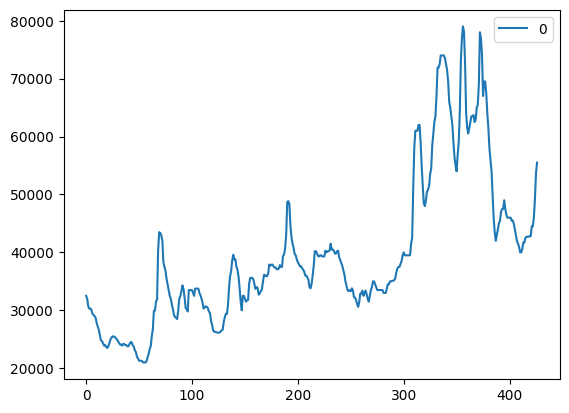

In [12]:
pd.DataFrame(X).plot()

In [501]:
X.shape

(427,)

In [539]:
X

array([32500, 32000, 30700, 30300, 30300, 30100, 29400, 29200, 29000,
       28700, 27800, 27200, 26600, 25700, 24800, 24700, 24300, 23900,
       24000, 23700, 23500, 23800, 24400, 25000, 25300, 25500, 25500,
       25400, 25200, 25000, 24700, 24400, 24100, 24100, 23900, 24200,
       24200, 24000, 24000, 23800, 23800, 24200, 24500, 24500, 23950,
       23750, 23100, 22800, 22000, 21700, 21300, 21300, 21300, 21200,
       21000, 21000, 21000, 21200, 21800, 22450, 23300, 23800, 25500,
       26700, 29900, 29950, 31500, 31900, 40300, 43500, 43350, 42950,
       42000, 38300, 37500, 36800, 35400, 34400, 33400, 32500, 32000,
       31000, 30200, 29200, 28850, 28700, 28500, 30000, 32000, 32500,
       33300, 34300, 33700, 32200, 30400, 30200, 29800, 33500, 33500,
       33500, 33500, 33000, 32500, 33750, 33750, 33750, 33750, 33000,
       32600, 32000, 31300, 30300, 30500, 30700, 30600, 30400, 29800,
       29500, 28200, 27500, 26500, 26300, 26300, 26200, 26150, 26150,
       26150, 26350,

In [502]:
y.shape

(427, 3)

In [13]:

# X = X[y.index]  # Пересинхронизируем индексы

X_train, X_holdout, y_train, y_holdout = train_test_split(
    y, X, test_size=0.2, shuffle=True, random_state=42
)

In [196]:
# from catboost import CatBoostRegressor
# model0 = CatBoostRegressor(iterations=10000, depth = 7, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
# early_stopping_rounds = 100 , random_state=42)
# # ---------------------
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error

# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
# model.fit(X_train, y_train)

# # Предсказание
# y_pred = model.predict(X_test)

# # Оценка модели
# mse = mean_squared_error(y_test, y_pred)
# print(f'MSE: {mse}')

In [ ]:
# df_train = df['Price'].iloc[:-28]
# df_test = df['Price'].iloc[-28:]

In [453]:

# model = AutoReg(df_train, lags=[i for i in range(40,200,15)]).fit()
# # best_score = [-1000, -1]
# # for i in range(1, 149):
# #     model = AutoReg(df_train, lags=i).fit()
# #     forecasts = model.forecast(50).tolist()
# #     if r2_score(forecasts, df_test) > best_score[0]:
# #         best_score = [r2_score(forecasts, df_test), i]
# # print(best_score)
# y = model.forecast(28).tolist()
# print('R2 score:', r2_score(y, df_test))
# print('MSE score:', mean_squared_error(y, df_test))
# print('MAE score:', mean_absolute_error(y, df_test))


# plt.figure(figsize=(14, 6))
# plt.plot(df_test.reset_index(drop=True), label='Фактические значения')
# plt.plot(y, label='Предсказанные значения')
# plt.title('Сравнение фактических и предсказанных значений')
# plt.xlabel('Индекс')
# plt.ylabel('Значения')
# plt.legend()
# plt.show()

In [14]:
# Обучение модели на X_train и y_train
model = AutoReg(y_train, lags=[i for i in range(1, 20, 5)], exog=X_train).fit()

c:\Users\Egor Bukharov\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [15]:


# Прогнозирование на тестовой выборке
y_pred = model.forecast(steps=len(X_holdout), exog=X_holdout).tolist()

c:\Users\Egor Bukharov\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Egor Bukharov\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:

# Оценка качества модели
print('R2 score:', r2_score(y_holdout, y_pred))
print('MSE score:', mean_squared_error(y_holdout, y_pred))
print('MAE score:', mean_absolute_error(y_holdout, y_pred))

R2 score: 0.5249385635147437
MSE score: 78543332.76746182
MAE score: 6780.220818570175


In [555]:
y_holdout

array([38300, 24100, 38800, 41500, 24700, 62500, 51500, 21200, 41700,
       77000, 26200, 35000, 60500, 34600, 32000, 61500, 67000, 29900,
       45500, 56500, 37700, 46000, 62000, 39650, 74000, 39300, 69500,
       36800, 33000, 42950, 33400, 39500, 34000, 49000, 33600, 51000,
       38600, 39500, 35000, 59000, 34500, 35500, 35000, 47500, 30300,
       46500, 42700, 67000, 23900, 29400, 42700, 32000, 77000, 33500,
       23800, 32500, 31400, 39800, 40200, 32000, 50000, 42000, 35300,
       44500, 26150, 26500, 42800, 36100, 23800, 38000, 31100, 62500,
       37000, 34400, 54500, 34000, 40300, 28000, 63500, 40000, 46000,
       66000, 35800, 30000, 39400, 71500])

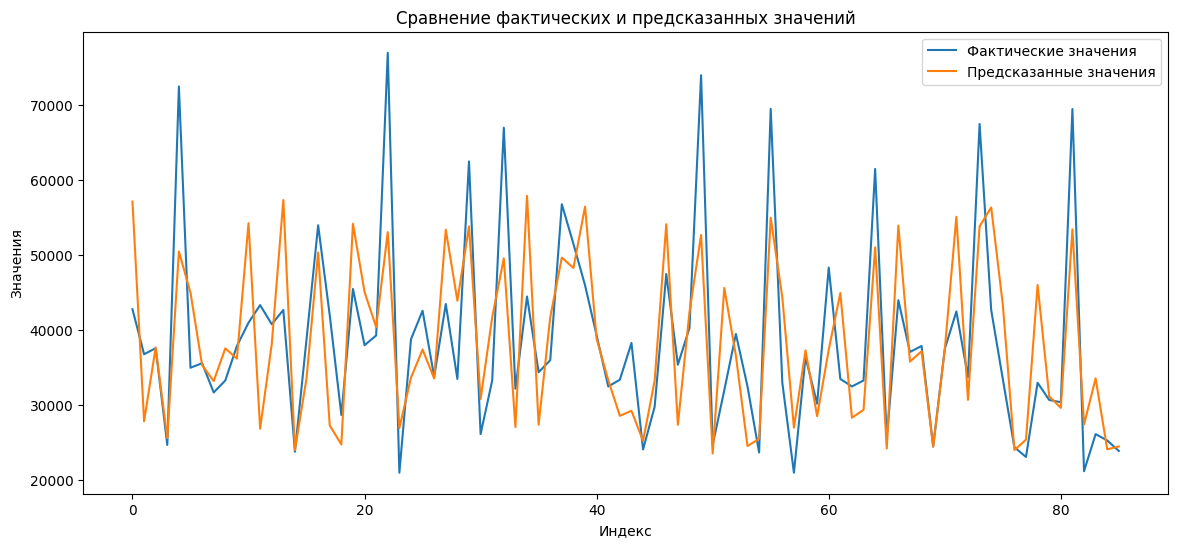

In [17]:
# Визуализация результатов
plt.figure(figsize=(14, 6))
plt.plot(y_holdout, label='Фактические значения')
plt.plot(y_pred, label='Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Индекс')
plt.ylabel('Значения')
plt.legend()
plt.show()

Было (до того как [я все перелопатил](https://github.com/Rainfue)):

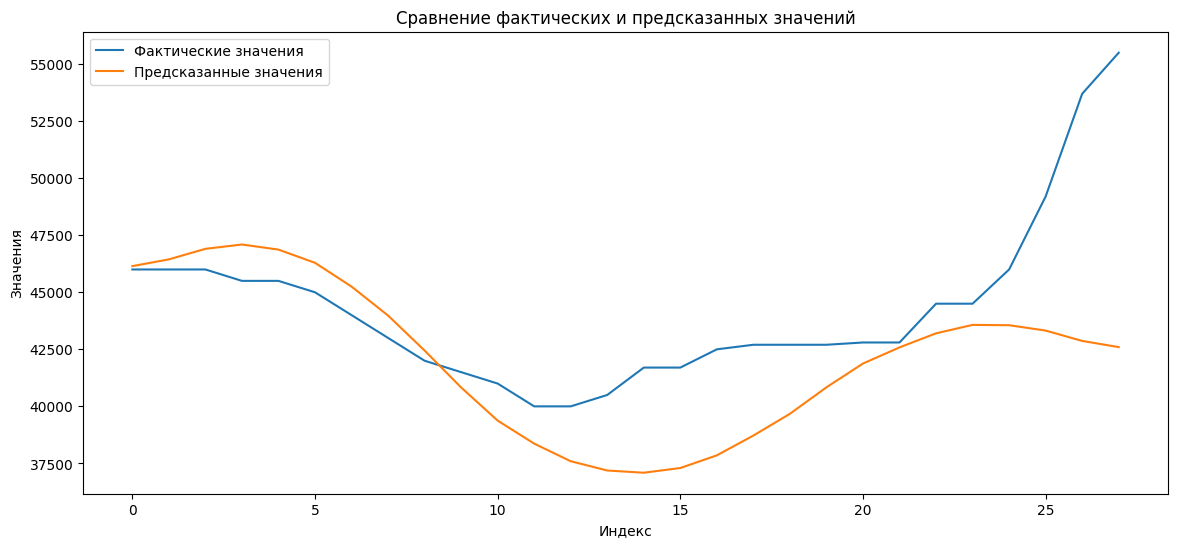

In [536]:
import joblib
joblib.dump(model, 'model.joblib')

import pickle
with open('model.pkl', 'wb') as f: pickle.dump(model, f)